Document by Mathijs Rozemuller

Goal: Compare FEWSNET data with the crop yield.
Is FEWSNET level 3 a good predictor of a low crop yield?


Conclusion:
- Crop yield data only exists until 2016 and the FEWSNET data from 2007, leaving a small time window
- The long term prediction is almost never a level 3 alert. (There were more level 3 predictions in 2016, but there's no crop yield data
- Therefore long term predictions are basically useless now. It might change if crop yield data could be inlcuded of later years.

- Current predictions of October more often have level 3 and have a very high likelyhood of a negative Z-score. However, no threshold can be made with a false positive rate exceeding ~40%.

# Calculate Exposed Population to IPC-Class 3

This script makes use of the FEWSNET Food Security classification, which is classified according to the [Integrated Phase Classification (IPC) V3.0](https://fews.net/IPC). 

The zips files to be downloaded in this script contains three files 

* _CS: Current Situation
* _ML1: Near-term projection - (next month)
* _ML2: Medium-term projection - (next four months)

The shapefiles contain the phases of food security for that period. The five phases are: 
1. Minimal
2. Stressed
3. Crisis
4. Emergency
5. Famine

Other additional values which might occur in the shapefiles include 
66 = water, 88 = parks, forests, reserves, 99 = No Data or Missing Data. 

More information [FEWSNET Food Securty Data](http://shapefiles.fews.net.s3.amazonaws.com/HFIC/FEWS_NET_Food_Security_Data_v3.pdf)

# Import packages

In [1]:
#!/usr/bin/env python
# coding: utf-8

#Make sure you have the ritht folder structure
#../data/Shapefile
# .../data/Shapefile/South_Africa_Zips

import subprocess
import requests
import urllib.request
import zipfile
import os
import shutil
import geopandas as gpd
from bs4 import BeautifulSoup
import urllib.request
from os import listdir
from os.path import isfile, join
import pandas as pd
import ee
import os
import glob
from zipfile import ZipFile
import datetime as dt

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
 
import descartes 
import mapclassify
from matplotlib.pyplot import figure
import numpy as np

plt.style.use('MathijsStyle')

**NOTE IF YOU ALREADY DOWNLOADED THE DATA, SCROLL DOWN TO START THE SCRIPT FROM 2.**

# 1. Download data from FEWSNET via Google Earth Engine

In [2]:
ee.Authenticate()

Enter verification code: 4/1AY0e-g6dofu-ApjN1jDw-96uFW8folgba-dKHF3n9L_XE6f_UPMQRK5hBGE

Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
ex = ['.shp', '.prj', '.dbf', '.shx']
file_paths = []
i=1

def zipshape(directory,export):
    for (root, directories, files) in os.walk(directory):
        for filename in files:
            if filename.endswith('.shp'):
                file_paths=[]
                filebase = filename.split('.')[0]
                try:
                    for things in ex:
                        if os.path.exists(os.path.join(root, filebase+things)):
                            filepath = os.path.join(root, filebase+things)
                            #print(filepath)
                            file_paths.append(filepath)
                    os.chdir(export)
                    if not os.path.exists(filebase+'.zip') and int(len(file_paths))==int(4):
                        with ZipFile(filebase+'.zip','w') as zip:
                            print("Creating zipped folder "+str(filebase)+'.zip'+' at '+str(export))
                            # writing each file one by one
                            for file in file_paths:
                                fname=os.path.basename(file)
                                zip.write(file,fname)
                    else:
                        print('File already exists: '+str(filebase+'.zip')+' SKIPPING')
                except:
                    pass


In [4]:
os.getcwd() #current working directory

'C:\\Users\\wmroz\\Nextcloud\\Rode Kruis\\FEWSNET skill assessment'

In [5]:
mypath = r"C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT"

#make the files data/Shapefile/South_Africa_Zips/

Create URL For the Area of interest, copy-paste the url from the browser and change the page=number into **page={0}".format(pagenum)** 

In [9]:
countryID = 34

url_download_list_zip = []

for pagenum in range (0,100):
    #Main page url for Western Africa
    #url = "https://fews.net/fews-data/333?tid=11&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    #url = "https://fews.net/fews-data/333?tid=23&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    # Main page url for East Africa
    #url = "http://fews.net/fews-data/333?tid=23&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    #Main page url for Southern Africa
    #url = "https://fews.net/fews-data/333?tid="+str(countryID)+"&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=12&page={0}".format(pagenum)
    url = "https://fews.net/fews-data/333?tid=34&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=12&page={0}".format(pagenum)
    #url = "https://fews.net/fews-data/333?tid=34&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2021&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=1".format(pagenum)

    print("Page number:" + str(pagenum))
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, from_encoding=resp.info().get_param('charset'))
    link_list = []
    
    # Find all links from main page
    for link in soup.find_all('a', href=True): 
        link_list.append(link['href'])
        
    # if it contains node, it mains that there is data on that page number
    if any("/node/" in s for s in link_list):
        
        # we only need the content link that links to the zipfile data (shapefiles)
        url_download_list = [s for s in link_list if "/content/" in s]
        
        #Find all zip files and on that link and save that in a list
        for downloadurl in url_download_list:
            resp = urllib.request.urlopen("http://fews.net/{0}".format(downloadurl))
            soup = BeautifulSoup(resp, "lxml", from_encoding=resp.info().get_param('charset'))
            
            link_list = []
            for link in soup.find_all('a', href=True): 
                link_list.append(link['href'])
            url_download_list_zip.append([s for s in link_list if ".zip" in s][0])  
    else:
        break
        
# zip occurs twice in the extracted website link list, remove duplicates:        
url_download_list_zip = list(set(url_download_list_zip))


Page number:0
Page number:1
Page number:2
Page number:3
Page number:4
Page number:5
Page number:6


In [10]:
url_download_list_zip

['http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201802.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201007.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201706.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201610.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201301.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201307.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201404.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa202006.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201501.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201702.zip',
 'http://s3.amazonaws.com/shapefiles.fews.net/HFIC/SA/southern-africa202005.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201310.zip',
 'http://shapefi

In [14]:
for zipfile_url in url_download_list_zip:

    filename = zipfile_url.rsplit('/', 1)[-1]

    print("Downloading shapefile {0}".format(filename))

    urllib.request.urlretrieve('{0}'.format(zipfile_url), '{0}/South_Africa_Zips/{1}'.format(mypath, filename))
    # Extract all files into a single folder:
    archive = zipfile.ZipFile('{0}/South_Africa_Zips/{1}'.format(mypath, filename), 'r')
    archive.extractall(path="{0}/South_Africa_Assets/".format(mypath))


In [15]:
# Convert files to zips in the folder

zipshape(mypath+r"/South_Africa_Assets",
         mypath+r"/South_Africa_Assets_Processed")

Creating zipped folder Lakes.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200907_CS.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200907_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200907_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200910_CS.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200910_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_200910_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201001_CS.z

Creating zipped folder SA_201407_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201410_CS.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201410_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201410_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201501_CS.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201501_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201501_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_201

Creating zipped folder SA_202005_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202005_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202006_CS.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202006_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202006_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202007_ML1.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_202007_ML2.zip at C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT/South_Africa_Assets_Processed
Creating zipped folder SA_20

In [19]:
# order into three folders 
mypath2=mypath
onlyfiles = [f for f in listdir(mypath2 + "/South_Africa_Assets_Processed/") if isfile(join(mypath2 + "/South_Africa_Assets_Processed/", f))]
# do this only one time 
try:
    shutil.rmtree(mypath2 + r"/CS") 
    shutil.rmtree(mypath2 + r"/ML1") 
    shutil.rmtree(mypath2 + r"/ML2") 
except:
    print("directory doesn't excist yet")
os.mkdir(mypath2 + r"/CS")
os.mkdir(mypath2 + r"/ML1")
os.mkdir(mypath2 + r"/ML2")


In [20]:
CS = [s for s in onlyfiles if "CS" in s]

In [26]:
#for file in CS:
#    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/CS")

#Note the name of the files, using the correct country area
#EA201702_CS linked to the eastern africa ipc outlooks
#in this case we are interested in Southern Africa, so SA201702_CS
os.rename(mypath2 + r"/CS/SA_201702_CS.zip", mypath2 + r"/CS/SA_201702_CS.zip")
ML1 = [s for s in onlyfiles if "ML1" in s]

for file in ML1:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/ML1")
    
ML2 = [s for s in onlyfiles if "ML2" in s]
for file in ML2:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/ML2")


## 2. RUN SCRIPT FROM HERE IF YOU HAVE THE DATA ALREADY

In [6]:
#mypath2='D:/Drought_IBF/zwe/data/Shapefile'
mypath2=r"C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT"

CS = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]
ML1 = [f for f in listdir(mypath2 + "/ML1/") if isfile(join(mypath2 + "/ML1/", f))]
ML2 = [f for f in listdir(mypath2 + "/ML2/") if isfile(join(mypath2 + "/ML2/", f))]

In [7]:
path='D:/Drought_IBF/zwe/data'
print(CS)
mypath2

['SA_200907_CS.zip', 'SA_200910_CS.zip', 'SA_201001_CS.zip', 'SA_201004_CS.zip', 'SA_201007_CS.zip', 'SA_201010_CS.zip', 'SA_201101_CS.zip', 'SA_201104_CS.zip', 'SA_201107_CS.zip', 'SA_201110_CS.zip', 'SA_201201_CS.zip', 'SA_201204_CS.zip', 'SA_201207_CS.zip', 'SA_201210_CS.zip', 'SA_201301_CS.zip', 'SA_201304_CS.zip', 'SA_201307_CS.zip', 'SA_201310_CS.zip', 'SA_201401_CS.zip', 'SA_201404_CS.zip', 'SA_201407_CS.zip', 'SA_201410_CS.zip', 'SA_201501_CS.zip', 'SA_201504_CS.zip', 'SA_201507_CS.zip', 'SA_201510_CS.zip', 'SA_201602_CS.zip', 'SA_201606_CS.zip', 'SA_201610_CS.zip', 'SA_201702_CS.zip', 'SA_201706_CS.zip', 'SA_201710_CS.zip', 'SA_201802_CS.zip', 'SA_201806_CS.zip', 'SA_201810_CS.zip', 'SA_201812_CS.zip', 'SA_201902_CS.zip', 'SA_201906_CS.zip', 'SA_201910_CS.zip', 'SA_202002_CS.zip', 'SA_202006_CS.zip', 'SA_202010_CS.zip']


'C:\\Users\\wmroz\\Nextcloud\\Rode Kruis\\FEWSNET skill assessment\\SFT'

### Import shapefiles 

In [8]:
############ ZIMBABWE ############

zwe_lzh = gpd.read_file(r'C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\data\ZW_LHZ_2011\ZW_LHZ_2011.shp') #Livelihood zones
district =gpd.read_file(r'C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\data\pop_recalc\pop_recalc.shp') #Population Data

## ONEDRIVE FOLDERS ##
##[PRJ] FbF - Zimbabwe - Danish Red Cross . 3.Data - Hazard exposure, vulnerability > Admin > pop_recal.zip 
##[PRJ] FbF - Zimbabwe - Danish Red Cross . 3.Data - Hazard exposure, vulnerability > zwe_livelihoodzones > ZW_LHZ_2011.zip

In [9]:
#district has go all the different districts, population size etc. in Zimbabwe


In [10]:
#This reads the CS data.
df_list=list()
for file in CS[:]:
    print(file)
    CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +file)
    gdf_adm2_cs_merged = gpd.overlay(district, CS_,how='intersection') 
    gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area
    df=gdf_adm2_cs_merged.query('CS < 6')
    idx = df.groupby(['ADM2_EN'])['area'].transform(max)==df['area'] #sort it
    df=df[idx]
    df=df[['ADM2_PCODE', 'CS', '_sum']]
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list.append(df.query('CS != "NaN"')) #CS not equal tot NaN
    
df1 = pd.concat(df_list)
df1_Comb = df1_Comb.astype({"_sum": int})

df1.to_csv(r'C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT\zwe_ipc.csv')
#df1.to_csv('D:/Drought_IBF/zwe/data/zwe_ipc.csv')

SA_200907_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_200910_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201001_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201004_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201007_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201010_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201101_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201104_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201107_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201110_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201201_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201204_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201207_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201210_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201301_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201304_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201307_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201310_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201401_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201404_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201407_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201410_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201501_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201504_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201507_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201510_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201602_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201606_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201610_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201702_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201706_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201710_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201802_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201806_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201810_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201812_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201902_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201906_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_201910_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_202002_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_202006_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


SA_202010_CS.zip


<ipython-input-10-e117c485fa33>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area


NameError: name 'df1_Comb' is not defined

In [ ]:
#Read the ML2 data
df_list_ML2=list()
for file in ML2:
    print(file)
    ML2_ = gpd.read_file('zip://' +mypath2 + "/ML2/" +file)
    gdf_adm2_cs_merged = gpd.overlay(district, ML2_,how='intersection') 
    gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area
    df=gdf_adm2_cs_merged.query('ML2 < 6')
    idx = df.groupby(['ADM2_EN'])['area'].transform(max)==df['area'] #sort it
    df=df[idx]
    df=df[['ADM2_PCODE', 'ML2', '_sum']]
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list_ML2.append(df.query('ML2 != "NaN"')) #CS not equal tot NaN
    
df1_ML2 = pd.concat(df_list_ML2)
df1_ML2 = df1.astype({"_sum": int})
#df1_ML2=df1_ML2.drop(['_sum'],axis=1)
#df1.to_csv(r'C:\Users\wmroz\Nextcloud\Rode Kruis\FEWSNET skill assessment\SFT\zwe_ipc.csv')
#df1.to_csv('D:/Drought_IBF/zwe/data/zwe_ipc.csv')



In [ ]:
df1_Comb = df1_ML2.merge(df1, on = ['ADM2_PCODE','Date','year'])

### IPC 3 Class Exposed Population 

In [748]:
#Calculate the total population, in order to set a threshold value based on percentage exposed. 
adm2_pop = df1_Comb.groupby(['ADM2_PCODE']).max().reset_index() #groupby groups across this column. It takes the max pop
total_pop = adm2_pop['_sum'].sum()
total_pop

14350675

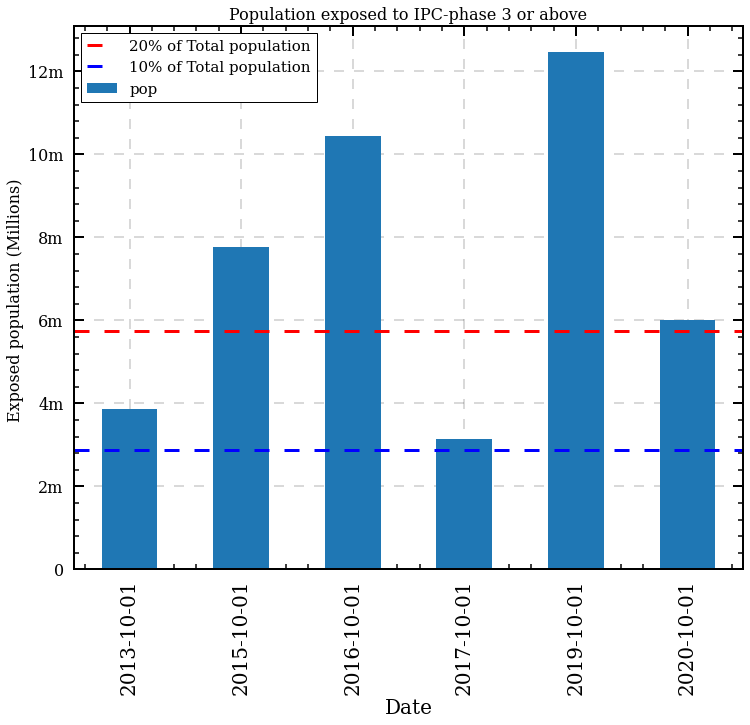

In [749]:
# Merge conflict events with regions they occurred in
fig, ax = plt.subplots(figsize = (12,10)) 

df1_Comb['pop']= df1_Comb['_sum'] #just renaming the total population
df2=df1_Comb.groupby(['CS','Date']).sum().reset_index() #sort by both the date and the population
oct_mask = pd.to_datetime(df2['Date']).map(lambda x:x.month) == 10 #selecting the 10th month
df3 = df2[oct_mask]
#Select all years where CS exceeds 2 and plot the pop
df3.query('CS>2').plot.bar(x='Date',y= 'pop',ax=ax,legend=False)
 

plt.title('Population exposed to IPC-phase 3 or above',fontsize='16')
ax.set_yticklabels(['0','2m', '4m','6m','8m','10m' ,'12m', '14m'],fontsize='16')
ax.set_ylabel('Exposed population (Millions) ',fontsize='16')
plt.axhline(y=(0.2*total_pop), color='r', linestyle='dashed', label='20% of Total population')
plt.axhline(y=(0.1*total_pop), color='b', linestyle='dashed', label='10% of Total population') 
plt.legend()

#plt.savefig('D:/Drought_IBF/zwe/outcome/zwe_ipc_class3_.png')

In [ ]:
years=pd.unique(pd.to_datetime(df2['Date']).map(lambda x:x.year))
df2 = district.merge(df1_Comb, on = 'ADM2_PCODE') #This merges the district info with the data along the 'ADM2_PCODE' axis


### FEWSNET IPC Maps  

In [750]:
# Several plots will be generated with the function plot_geo:
def plot_geo_acc(df1, district,year):
    fig, ax = plt.subplots(figsize = (20,10)) 
    ax.axis("off")
    df1=df1.query('CS > 1')
    df1 = df1.astype({"CS": int})
    colors2=['#f0f9e8','#ffffb2','#fe9929','#e31a1c','#d94701']
    cmap1 = ListedColormap(colors2)
    #df1.plot(column ='CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.1, edgecolor='0.8',vmin=1, vmax=5)
    district.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
    plt.title('FEWS NET IPC-%s '%year)

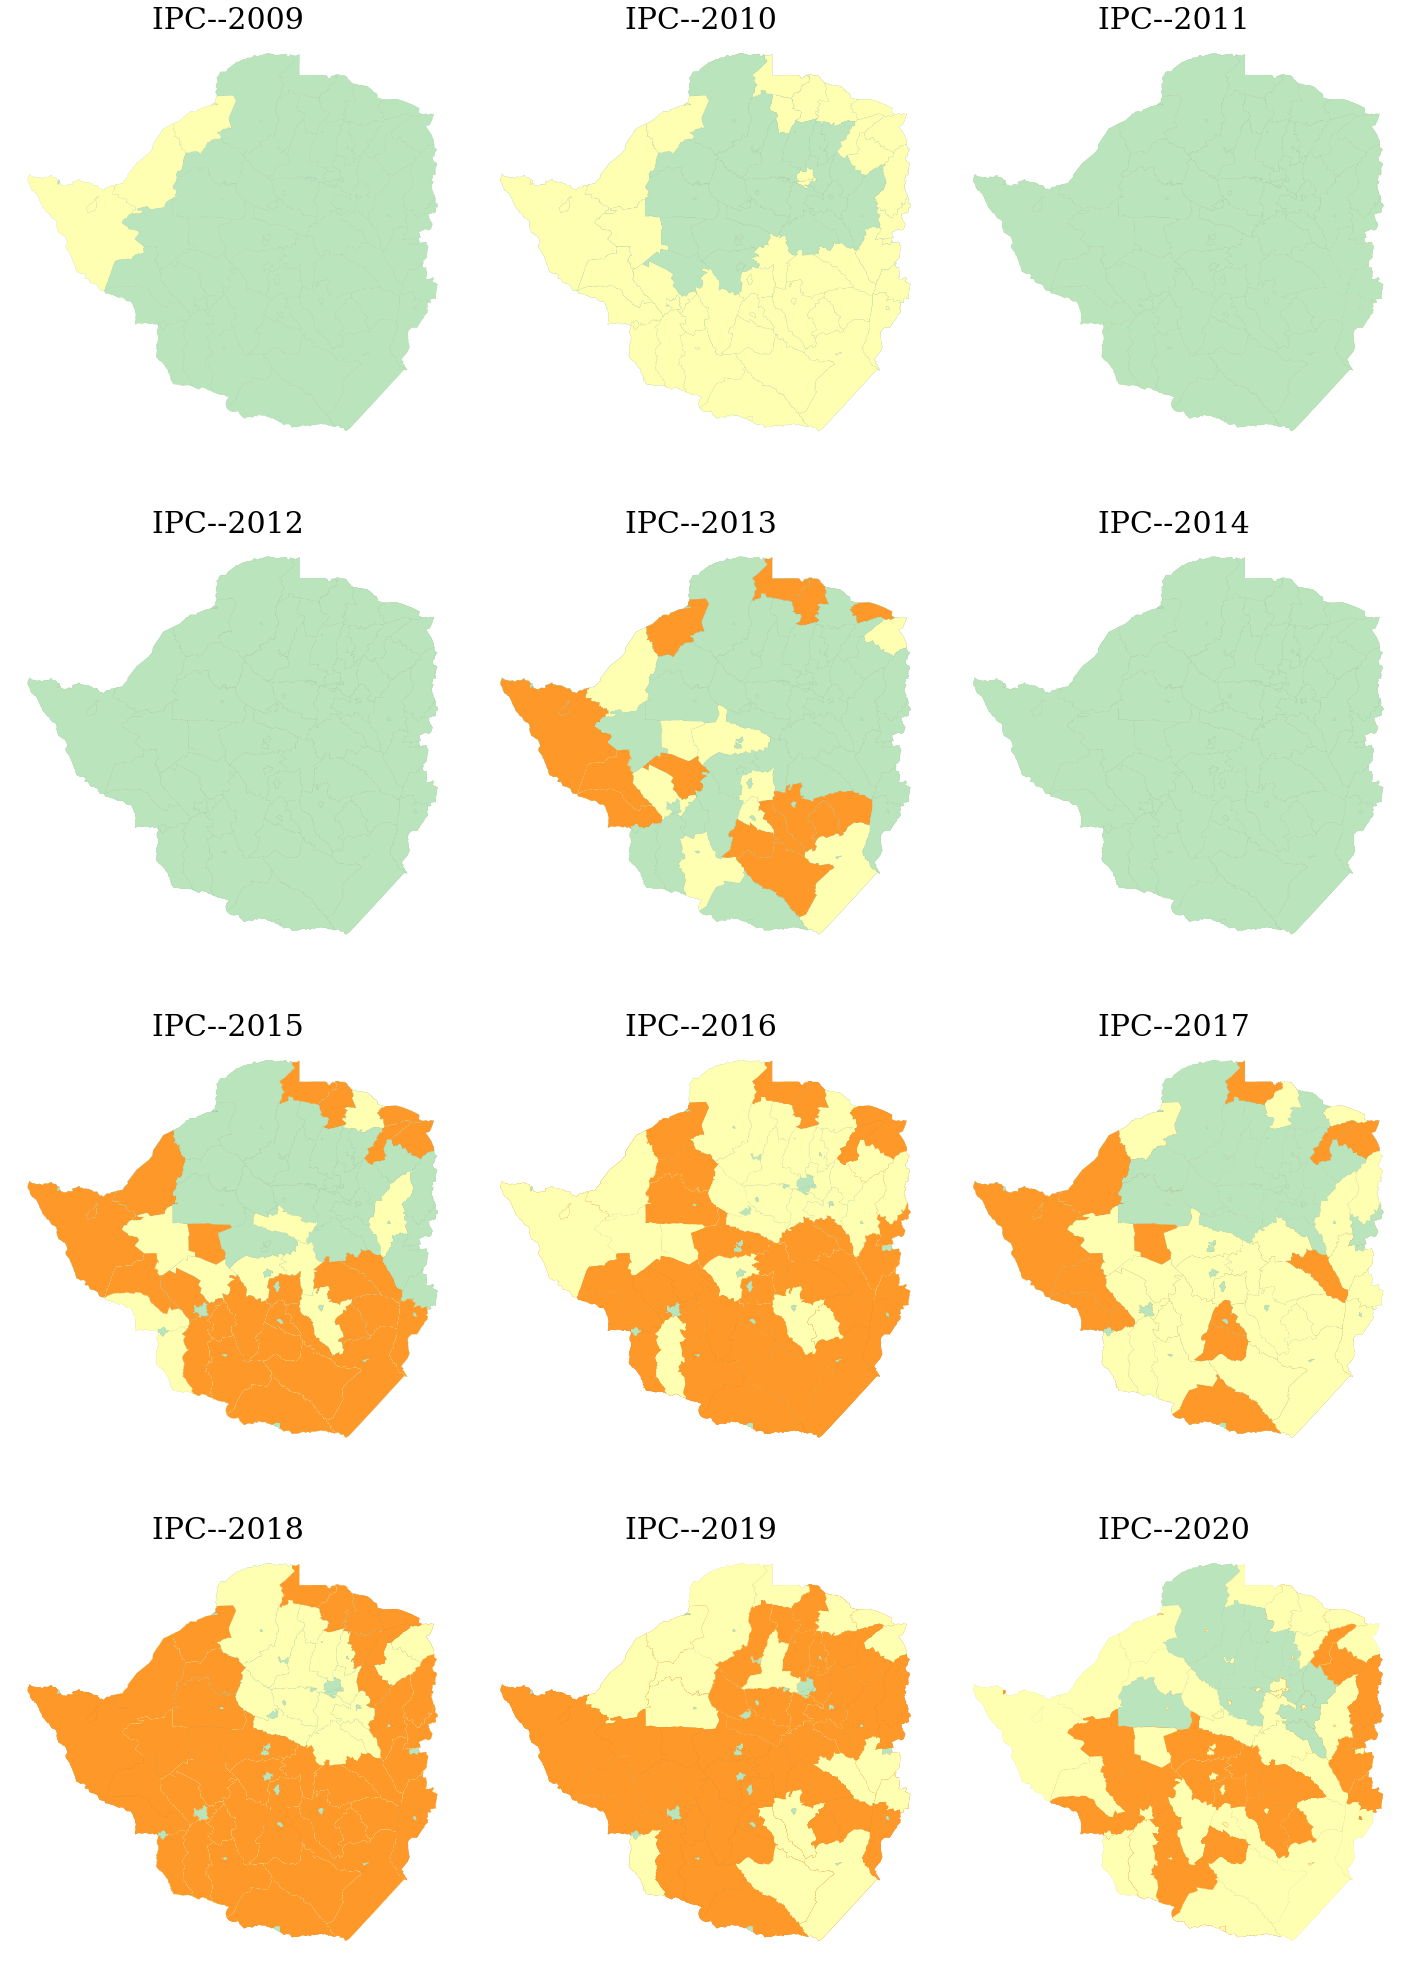

In [751]:
fig1= plt.figure( figsize=(20, 30))
#c=9
for i,Y in enumerate(years):
    
    ax = fig1.add_subplot(4, int(float(len(years)+3)/4.), i+1)  # create an axes object in the figure
    
    plot_df=df2.query('year==%s'% (Y)) #select a certain year
    year='-%s'% (Y)
    df=plot_df.query('CS > 1') #select data with CS>1
    df = df.astype({"CS": int})
    #colors2=["#bababa","#e0e0e0","#ffffff","#fb6a4a","#de2d26"]
    #colors2=['#f6eff7','#f0f9e8','#ffffb2','#fe9929','#e31a1c','#d94701']
    colors2=['#f0f9e8','#bae4bc','#ffffb2','#fe9929','#e31a1c','#59140d']
    cmap1 = ListedColormap(colors2)
    #plot the map allong column CS
    s1=plot_df.plot(column = 'CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.02, edgecolor='0.4',vmin=-0.5, vmax=6)
    ax.axis('off')
    #plt.clim(1,5) 
    #POSTO.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
    plt.title('IPC-%s '%year,fontsize='30')
    #fig.colorbar(cs, ax=ax, shrink=0.9)
    #c=c+1
    plt.tight_layout()

# Do the anomaly detection

In [1102]:
#load data
Yield_data=pd.read_csv(os.path.split(mypath2)[0]+r'\data\zwe_cropyield\all_yield_global_dataset.csv')
Yield_data['Z-score']=np.nan #add column for the Z-scores
Yield_data['Z-moveAv']=np.nan #add column for the Z-scores
Yield_data['yield_movAv']=np.nan #add column for the moving average
Yield_data['yield_movDev']=np.nan #add column for the difference with respect ot the moving average
Yield_data['Anomaly']=np.nan #add column for the difference with respect ot the moving average
Yield_data['AnomalyMovAv']=np.nan #add column for the difference with respect ot the moving average

Yield_data.columns

Index(['pcode', 'year', 'yield', 'Z-score', 'Z-moveAv', 'yield_movAv',
       'yield_movDev', 'Anomaly', 'AnomalyMovAv'],
      dtype='object')

In [1103]:
Zsc = lambda x : (x-x.mean())/x.std()
Nav=5 #Use the moving average of the last 5 years

#Compute the Z-score
PCodes=Yield_data.pcode.unique()
for pc in PCodes:
    sel=np.logical_and(Yield_data['pcode']==pc,~np.isnan(Yield_data['yield']))
    Yield_data.loc[sel,'Z-score']=Zsc(Yield_data['yield'][sel])

    #Compute the deviation from the Nav (5) year average
    for Y in Yield_data[sel]['year']:
        sel2=np.logical_and(Yield_data[sel]['year']>Y-Nav,Yield_data[sel]['year']<=Y)
        if sel2.sum()==Nav:
            Ym=Yield_data[sel][sel2]['yield'].mean()
            #sY=Yield_data.query('year == @Y and pcode == @pc')
            sY=np.logical_and(Yield_data['year']==Y,Yield_data['pcode']==pc)
            Yield_data.loc[sY,'yield_movAv']=Ym
Yield_data['yield_movDev']=Yield_data['yield']-Yield_data['yield_movAv']

for pc in PCodes:
    sel=np.logical_and(Yield_data['pcode']==pc,~np.isnan(Yield_data['yield_movDev']))
    Yield_data.loc[sel,'Z-moveAv']=Zsc(Yield_data['yield_movDev'][sel])
            
#Yield_data.groupby([])

In [1104]:
Yield_data['Z-moveAv_NextYear']=0#np.nan
for pc in Yield_data['pcode'].unique():
    yrs=Yield_data.loc[Yield_data['pcode']==pc,'year']
    for y in yrs:
        if y+1 in np.array(yrs):
            nv_=Yield_data[ ( Yield_data.pcode == pc ) & (Yield_data.year==y+1)]['Z-moveAv']    
            Yield_data.loc[ ( Yield_data.pcode == pc ) & (Yield_data.year==y) , 'Z-moveAv_NextYear'] = np.copy(nv_)

In [1105]:
#Yield_data[Yield_data.pcode==Yield_data['pcode'].unique()[5]]

Fraction of anomalies using a Z-score threshold of 0 : 0.291
Fraction of anomalies using deviate Z-score threshold of 0 : 0.182


[0.03375527426160337,
 0.08157524613220815,
 0.14627285513361463,
 0.2489451476793249,
 0.5035161744022504]

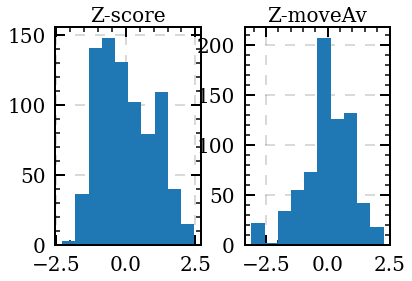

In [1106]:
#Anomaly detection using the Z-score
Yield_data.hist(column=['Z-score','Z-moveAv'])
Yield_data['LZCODE']=Yield_data['pcode']

AnomThr=-.5

Yield_data['Anomaly']=Yield_data['Z-score']<AnomThr
Yield_data['AnomalyMovAv']=Yield_data['Z-moveAv']<AnomThr
print('Fraction of anomalies using a Z-score threshold of %d : %2.3f'%(AnomThr,Yield_data['Anomaly'].mean()))
print('Fraction of anomalies using deviate Z-score threshold of %d : %2.3f'%(AnomThr,Yield_data['AnomalyMovAv'].mean()))

d=Yield_data['Z-moveAv'][~np.isnan(Yield_data['Z-moveAv'])]
[(d<a).mean() for a in [-2,-1.5,-1,-0.5,0]]

# Match the pcodes with the livelihoodzones

In [1107]:
Intc=gpd.overlay(district, zwe_lzh,how='intersection') 
Intc["area_overlap"]=Intc['geometry'].area
Intc["area_LZtot"]=np.nan

<ipython-input-1107-b9f0289810fa>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Intc["area_overlap"]=Intc['geometry'].area


In [1108]:
IntSel=Intc[['ADM2_PCODE','area_overlap','LZCODE','area_LZtot']]
for Pcode in IntSel['ADM2_PCODE'].unique():
    totArea=IntSel[IntSel['ADM2_PCODE'] == Pcode]['area_overlap'].sum()
    IntSel.loc[IntSel.ADM2_PCODE==Pcode, 'area_LZtot'] = totArea

idx=IntSel.groupby(['ADM2_PCODE'])['area_overlap'].transform(max) == IntSel['area_overlap']
IntSel_maxCorArea=IntSel[idx]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [1109]:
#merge the yield data with the translation data (from the districts to the livelihood zones)

df3=Yield_data.dropna().merge(IntSel_maxCorArea, on = 'LZCODE')
#There's fewer livelihood zones than the original 91, because not all of them have data. The dropna kills 5 zones.

In [1126]:
# Now also merge the alarm data in here
#df4 = df3.merge(IntSel_maxCorArea, on = 'ADM2_PCODE') #This merges the district info with the data along the 'ADM2_PCODE' axis
df4 = df3.merge(df2, on = ['ADM2_PCODE','year']) #This merges the district info with the data along the 'ADM2_PCODE' axis
df4['alertCS']=df4['CS']>=3
df4['alertML2']=df4['ML2']>=3
df4.loc[df4['Z-moveAv_NextYear']==0,'Z-moveAv_NextYear']=np.nan

In [1127]:
#If needed use a different anomaly threshold
AnomThr=-0.2

df4['Anomaly']=df4['Z-score']<AnomThr
df4['AnomalyMovAv']=df4['Z-moveAv']<AnomThr
df4['AnomalyMovAvNY']=df4['Z-moveAv_NextYear']<AnomThr

print('Fraction of anomalies using a Z-score threshold of %d : %2.3f'%(AnomThr,df4['Anomaly'].mean()))
print('Fraction of anomalies using deviate Z-score threshold of %d : %2.3f'%(AnomThr,df4['AnomalyMovAv'].mean()))

Fraction of anomalies using a Z-score threshold of 0 : 0.758
Fraction of anomalies using deviate Z-score threshold of 0 : 0.281


In [1128]:
#Only select the 10th month
idx = pd.to_datetime(df4['Date']).map(lambda x:x.month) == 10
df5=df4[idx]

In [1129]:
def PNmat(A,B):
    #Assumes A is the true matrix and B the predictor
    #Computes the true/false positive/negative terms
    #returns [TP,TN,FP,FN]
    TP=np.logical_and(A,B).sum()
    TN=np.logical_and(~A,~B).sum()
    FP=np.logical_and(A,~B).sum()
    FN=np.logical_and(~A,B).sum()
    return(TP,TN,FP,FN)

dfPNm = lambda x,n1,n2:PNmat(x[n1],x[n2])
dfPNmNextYear = lambda x,n1,n2:PNmat(x[n1][1:],x[n2][:-1])

### Prediction of the current FEWSNET alerty level situation in October for the same year

In [1130]:
df_EffectivityCS=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    TFmat=dfPNm(df5[df5['ADM2_PCODE']==Pcode],'AnomalyMovAv','alertCS')#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_EffectivityCS.loc[i]=rd
    
    #print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_EffectivityCS

,ADM2_PCODE,TP,TN,FP,FN
0,ZW1601,2,6,0,0
1,ZW1606,1,6,1,0
2,ZW1307,0,6,2,0
3,ZW1702,0,5,0,0
4,ZW1502,1,5,1,1
...,...,...,...,...,...
56,ZW1802,2,5,1,0
57,ZW1402,0,5,3,0
58,ZW1503,2,5,1,0
59,ZW1404,2,5,1,0


In [1131]:
df_EffectivityCS.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                           62
TN                                                          338
FP                                                           73
FN                                                           12
dtype: object

In [1132]:
print(df_EffectivityCS.to_string())

   ADM2_PCODE TP TN FP FN
0      ZW1601  2  6  0  0
1      ZW1606  1  6  1  0
2      ZW1307  0  6  2  0
3      ZW1702  0  5  0  0
4      ZW1502  1  5  1  1
5      ZW1505  1  6  1  0
6      ZW1305  2  5  1  0
7      ZW1107  0  5  3  0
8      ZW1206  3  5  0  0
9      ZW1309  2  5  1  0
10     ZW1201  0  6  2  0
11     ZW1401  0  6  2  0
12     ZW1302  0  6  2  0
13     ZW1203  0  6  2  0
14     ZW1303  1  6  1  0
15     ZW1405  0  6  2  0
16     ZW1304  0  6  2  0
17     ZW1204  0  6  2  0
18     ZW1308  0  6  2  0
19     ZW1406  0  6  2  0
20     ZW1104  0  6  2  0
21     ZW1427  0  6  2  0
22     ZW1205  0  6  2  0
23     ZW1306  0  6  2  0
24     ZW1207  0  6  2  0
25     ZW1521  1  5  1  1
26     ZW1504  0  6  2  0
27     ZW1703  1  6  1  0
28     ZW1428  0  6  2  0
29     ZW1101  2  6  0  0
30     ZW1102  1  6  1  0
31     ZW1804  2  6  0  0
32     ZW1805  0  5  2  1
33     ZW1105  1  6  1  0
34     ZW1807  1  5  1  1
35     ZW1708  2  6  0  0
36     ZW1706  2  5  0  1
37     ZW160

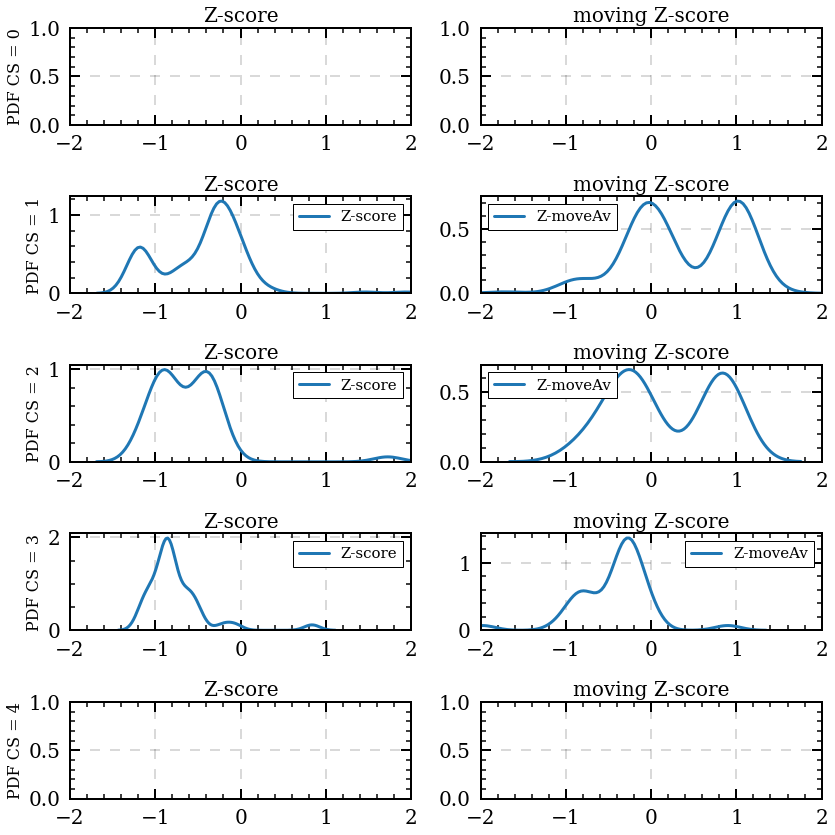

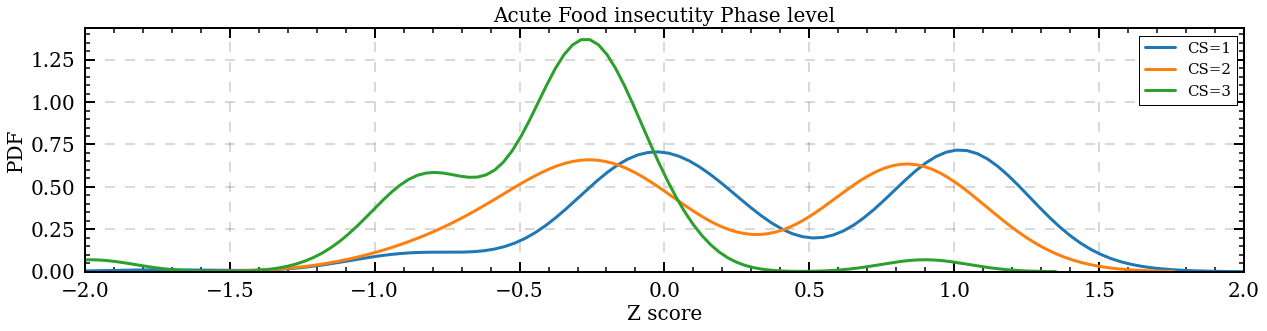

In [1133]:
#How do the CS levels (October) correspond to the yield of the same year?
plt.figure(figsize=(12,12))
for cs in range(5):
    Zsc=df5[df5['CS']==cs]['Z-score']
    ZscA=df5[df5['CS']==cs]['Z-moveAv']
    plt.subplot(5,2,2*cs+1)
    sns.kdeplot(Zsc)
    plt.title('Z-score')
    plt.ylabel(r'PDF CS = %d'%cs,fontsize=16)
    plt.xlim(-2.,2.)
    plt.subplot(5,2,2*cs+2)
    sns.kdeplot(ZscA)
    plt.title('moving Z-score')
    plt.xlim(-2.,2.)
plt.tight_layout()
plt.show()


plt.figure(figsize=(18,5))
plt.title('Acute Food insecutity Phase level')
for ip,cs in enumerate(np.arange(1,4)):
    ZscA=df5[df5['CS']==cs]['Z-moveAv']
    #plt.subplot(1,3,ip+1)
    plt.ylabel(r'PDF')
    sns.kdeplot(ZscA,label='CS=%d'%cs)
    #plt.title('moving Z-score')
    plt.xlim(-2.,2.)
    plt.xlabel('Z score')

plt.tight_layout()
plt.show()

### Comparing of the long term (level 2) FEWSNET alerty level prediction in October with the crop yield of next year

In [1134]:
def get2VShift(df,n1,n2):
    Y=np.array(df['year'])
    ML2d=np.array(df[n1])
    Anomal=np.array(df[n2])
    ML2new=[];yieldNew=[]
    for iy,y in enumerate(Y):
        loc=np.where(Y==y+1)[0]
        if len(loc)==1:
            ML2new.append(ML2d[iy]) #take the long term prediction from year x
            yieldNew.append(Anomal[loc[0]]) #and the yield from x+1
    ML2new=np.array(ML2new);yieldNew=np.array(yieldNew)
    return ML2new,yieldNew
    
#df5[df5['ADM2_PCODE']==Pcode]['year','AnomalyMovAv','ML2']

In [1135]:
df_Effectivity_ML2=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])

ML2All=[];yieldAll=[]
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    ML2new,yieldNew=get2VShift(df5[df5['ADM2_PCODE']==Pcode],'ML2','AnomalyMovAv')
    TFmat=PNmat(ML2new>=3,yieldNew)#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_Effectivity_ML2.loc[i]=rd
    ML2All.append(ML2new)
    yieldAll.append(yieldNew)
ML2All=np.hstack(ML2All)
yieldAll=np.hstack(yieldAll)
#print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_Effectivity_ML2

,ADM2_PCODE,TP,TN,FP,FN
0,ZW1601,0,5,0,2
1,ZW1606,0,5,0,2
2,ZW1307,0,5,0,2
3,ZW1702,0,4,0,0
4,ZW1502,0,5,0,2
...,...,...,...,...,...
56,ZW1802,0,4,0,3
57,ZW1402,0,4,0,3
58,ZW1503,0,3,1,3
59,ZW1404,0,3,1,3


In [1136]:
df_Effectivity_ML2.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                            5
TN                                                          286
FP                                                            3
FN                                                          130
dtype: object

In [1137]:
df_Effectivity_ML2=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    TFmat=dfPNm(df5[df5['ADM2_PCODE']==Pcode],'AnomalyMovAvNY','alertML2')#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_Effectivity_ML2.loc[i]=rd
    
    #print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_Effectivity_ML2

,ADM2_PCODE,TP,TN,FP,FN
0,ZW1601,0,5,2,1
1,ZW1606,0,5,2,1
2,ZW1307,0,6,2,0
3,ZW1702,0,5,0,0
4,ZW1502,0,5,2,1
...,...,...,...,...,...
56,ZW1802,0,4,3,1
57,ZW1402,0,5,3,0
58,ZW1503,0,4,3,1
59,ZW1404,0,3,3,2


In [1138]:
df_Effectivity_ML2.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                            5
TN                                                          306
FP                                                          130
FN                                                           44
dtype: object

1 229
2 188
3 8


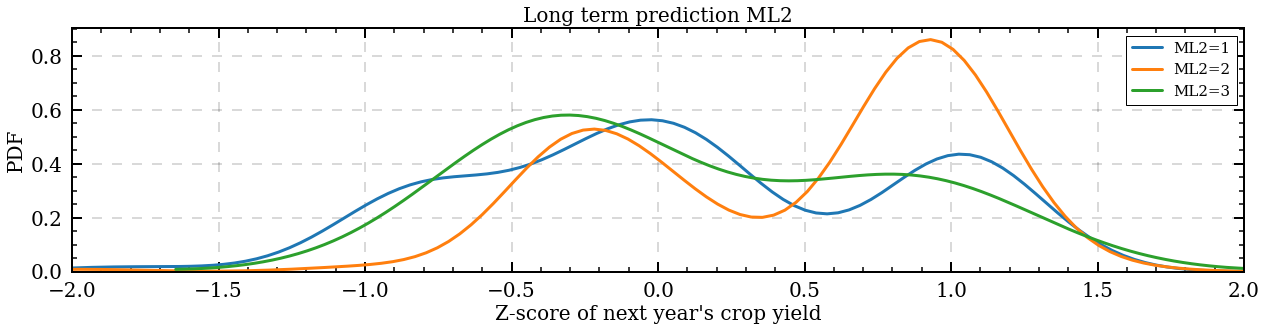

In [1152]:
plt.figure(figsize=(18,5))
plt.title('Long term prediction ML2')
for ip,level in enumerate(np.arange(1,4)):
    ZscA=df5[df5['ML2']==level]['Z-moveAv_NextYear'].dropna()
    print(level,len(ZscA))
    #plt.subplot(1,3,ip+1)
    plt.ylabel(r'PDF')
    sns.kdeplot(ZscA,label='ML2=%d'%level)
    #plt.title('moving Z-score')
    plt.xlim(-2.,2.)
    plt.xlabel("Z-score of next year's crop yield")

plt.tight_layout()
plt.show()